# Multi Axion System

In [6]:
%run observables.py
%run multi_axion.py
%run analysis_tools.py
%run plot_tools.py

def sim_multi_axion(Q, Lambda, thetas0, H_inf=1e8, Gamma_inf=1e8, tmax_axion=8e2, save=False):
    Q_inv = np.linalg.inv(Q)

    # simulate background cosmology
    energy_scale, conv_factor, rho_R_init, rho_inf_init, scale, tmax_inf, red_chem_pots_init = \
        init_system(H_inf, Gamma_inf, (Q, Lambda), multi_axion_field, tmax_axion)
    rh_sol, T_and_H_fn, T_and_H_and_T_dot_fn = decay_process.solve(tmax_inf, rho_R_init, rho_inf_init, scale, Gamma_inf)
    
    # simulate axion fields
    axsol = multi_axion_field.solve(np.hstack([thetas0, np.zeros(len(Lambda))]), (Q, Lambda), tmax_axion, T_and_H_fn, Gamma_inf)
    
    # plotting
    ts = np.geomspace(axsol.t[1], axsol.t[-1], 500)
    theta1s, theta2s, theta1_dots, theta2_dots = canoncial_states = axsol.sol(ts)

    plot_tools.plot_axion_field_evolution(multi_axion_field, (Q, Lambda), 1.0, 
        [(ts, canoncial_states)], show_steps=False, field_name="\\theta")
    if save: plt.savefig(os.path.join(plotpath, "multi_axion_canonical_field_evolution.pdf"), bbox_inches="tight")

    plot_config_space_2d(ts, theta1s, theta2s, canonical_names[0], canonical_names[1], 
                         "canonical basis", multi_axion_field.calc_V, (Q, Lambda))
    if save: plt.savefig(os.path.join(plotpath, "multi_axion_canonical_configspace.pdf"), bbox_inches="tight")

    # power spectra
    ts = np.linspace(0, axsol.t[-1], 500)
    theta1s, theta2s, theta1_dots, theta2_dots = canoncial_states = axsol.sol(ts)
    analyse_power_spectrum("canoncial", ts, theta1s, canoncial_states, multi_axion_field, (Q, Lambda))

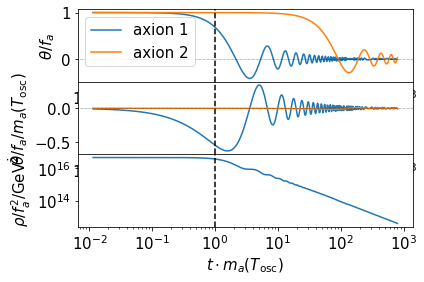

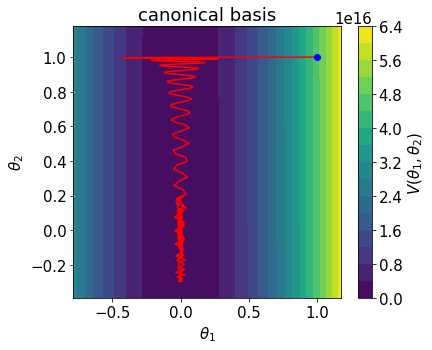

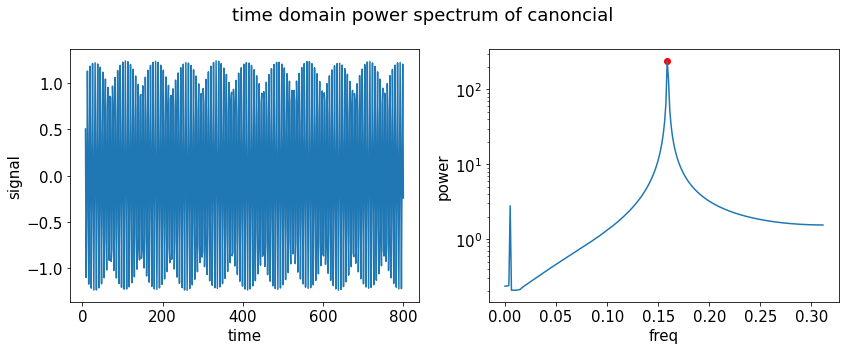

In [7]:
sim_multi_axion(np.array([[1,1], [1, 0]]), 1e7**2 * np.array([1, 1e3]), [1, 1])

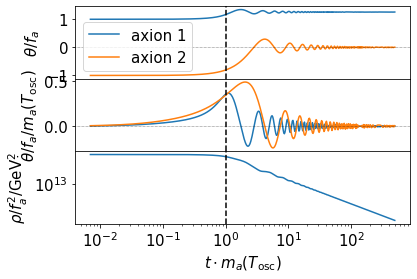

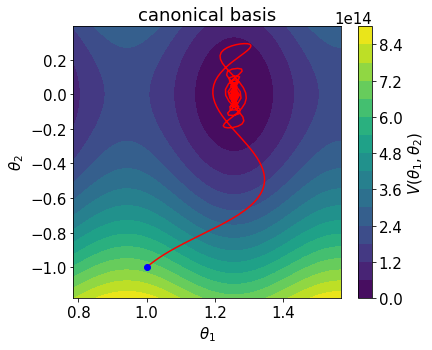

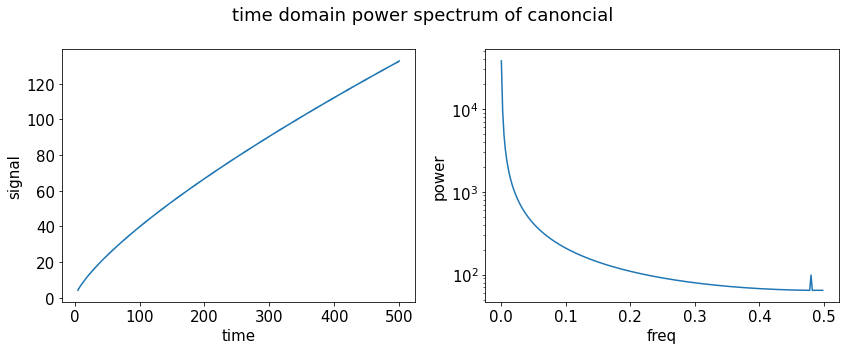

In [8]:
sim_multi_axion(np.array([[10,0], [0, 1]]), 1e7**2 * np.array([1, 1 + 10]), [1, -1], tmax_axion=5e2)